# 01 — Preprocessing & EDA (Beijing Multi-Site Air Quality)
Mục tiêu: tải dữ liệu, làm sạch, tạo nhãn phân lớp (AQI class theo PM2.5 24h mean), tạo đặc trưng thời gian + lag, và lưu `data/processed/cleaned.parquet`.

**Lưu ý:** nếu `USE_UCIMLREPO=True` thì notebook cần internet để tải dataset từ UCI.

In [4]:
USE_UCIMLREPO = False
RAW_ZIP_PATH = "../data/raw/PRSA2017_Data_20130301-20170228.zip"

OUTPUT_CLEANED_PATH = 'data/processed/cleaned.parquet'
LAG_HOURS=[1, 3, 24]


In [5]:
%pip install ucimlrepo
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add project root to Python path
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
    add_pm25_24h_and_label,
    add_time_features,
    add_lag_features,
)

OUT_PATH = (PROJECT_ROOT / OUTPUT_CLEANED_PATH).resolve()
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\quang\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
df_raw = load_beijing_air_quality(use_ucimlrepo=USE_UCIMLREPO, raw_zip_path=RAW_ZIP_PATH)
print('raw shape:', df_raw.shape)
df_raw.head()

raw shape: (420768, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [7]:
df = clean_air_quality_df(df_raw)
df = add_pm25_24h_and_label(df)
df = add_time_features(df)
df = add_lag_features(df, lag_hours=LAG_HOURS)
print('cleaned shape:', df.shape)
df[['datetime','station','PM2.5','pm25_24h','aqi_class']].head(10)

cleaned shape: (420768, 55)


,datetime,station,PM2.5,pm25_24h,aqi_class
0,2013-03-01 00:00:00,Aotizhongxin,4.0,NaN,NaN
1,2013-03-01 01:00:00,Aotizhongxin,8.0,NaN,NaN
2,2013-03-01 02:00:00,Aotizhongxin,7.0,NaN,NaN
3,2013-03-01 03:00:00,Aotizhongxin,6.0,NaN,NaN
4,2013-03-01 04:00:00,Aotizhongxin,3.0,NaN,NaN
5,2013-03-01 05:00:00,Aotizhongxin,5.0,NaN,NaN
6,2013-03-01 06:00:00,Aotizhongxin,3.0,NaN,NaN
7,2013-03-01 07:00:00,Aotizhongxin,3.0,NaN,NaN
8,2013-03-01 08:00:00,Aotizhongxin,3.0,NaN,NaN
9,2013-03-01 09:00:00,Aotizhongxin,3.0,NaN,NaN


In [8]:
# EDA nhanh: missingness và phân bố lớp
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate.head(20)

CO_lag24      0.049849
CO_lag3       0.049284
CO_lag1       0.049227
CO            0.049198
O3_lag24      0.032203
O3_lag3       0.031640
O3_lag1       0.031583
O3            0.031554
NO2_lag24     0.029446
NO2_lag3      0.028881
NO2_lag1      0.028823
NO2           0.028795
SO2_lag24     0.022091
SO2_lag3      0.021525
SO2_lag1      0.021468
SO2           0.021439
PM2.5         0.020769
aqi_class     0.018616
pm25_24h      0.018616
PM10_lag24    0.015990
dtype: float64

In [9]:
class_dist = df['aqi_class'].value_counts(dropna=False)
class_dist

aqi_class
Unhealthy                         148558
Moderate                          109549
Unhealthy_for_Sensitive_Groups     64731
Very_Unhealthy                     56242
Hazardous                          19931
Good                               13924
NaN                                 7833
Name: count, dtype: int64

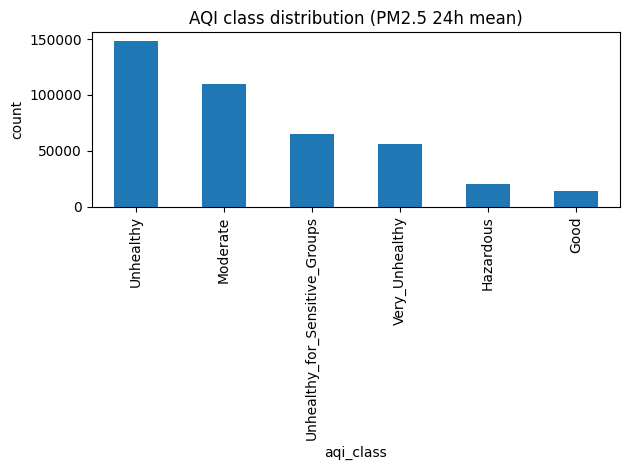

In [10]:
class_dist.drop(index=[x for x in class_dist.index if pd.isna(x)], errors='ignore').plot(kind='bar')
plt.title('AQI class distribution (PM2.5 24h mean)')
plt.ylabel('count')
plt.tight_layout()
plt.show()

## Q1: Bổ sung phân tích để hiểu dữ liệu chuỗi thời gian

Theo yêu cầu Q1, chúng ta cần kiểm tra:
1. Khoảng thời gian dữ liệu phủ (start/end) và xác nhận tần suất theo giờ
2. Tỷ lệ thiếu theo từng biến và thiếu theo thời gian
3. Boxplot/quantile để nhìn ngoại lai và phân phối lệch
4. Vẽ chuỗi PM2.5 theo thời gian (toàn giai đoạn + zoom 1-2 tháng)
5. Kiểm tra tự tương quan (lag 24h và 168h)
6. Kiểm tra tính dừng (ADF/KPSS)

In [11]:
# 1. Kiểm tra khoảng thời gian và tần suất
print("="*60)
print("1. KHOẢNG THỜI GIAN VÀ TẦN SUẤT")
print("="*60)
print(f"Start: {df['datetime'].min()}")
print(f"End: {df['datetime'].max()}")
print(f"Duration: {df['datetime'].max() - df['datetime'].min()}")
print(f"Total rows: {len(df):,}")
print(f"Number of stations: {df['station'].nunique()}")
print(f"Rows per station (expected): {len(df) // df['station'].nunique():,}")

# Kiểm tra tần suất theo giờ cho từng trạm
print("\nKiểm tra tần suất theo giờ (lấy 1 trạm mẫu):")
sample_station = df['station'].iloc[0]
station_df = df[df['station'] == sample_station].sort_values('datetime')
time_diff = station_df['datetime'].diff()
print(f"Trạm mẫu: {sample_station}")
print(f"Min diff: {time_diff.min()}")
print(f"Max diff: {time_diff.max()}")
print(f"Mode diff: {time_diff.mode()[0]}")
print(f"=> Tần suất: {'Hourly (liên tục)' if time_diff.mode()[0] == pd.Timedelta('1 hour') else 'Không đều'}")

1. KHOẢNG THỜI GIAN VÀ TẦN SUẤT
Start: 2013-03-01 00:00:00
End: 2017-02-28 23:00:00
Duration: 1460 days 23:00:00
Total rows: 420,768
Number of stations: 12
Rows per station (expected): 35,064

Kiểm tra tần suất theo giờ (lấy 1 trạm mẫu):
Trạm mẫu: Aotizhongxin
Min diff: 0 days 01:00:00
Max diff: 0 days 01:00:00
Mode diff: 0 days 01:00:00
=> Tần suất: Hourly (liên tục)


In [12]:
# 2. Tỷ lệ thiếu theo từng biến (chi tiết hơn)
print("\n" + "="*60)
print("2. TỶ LỆ THIẾU DỮ LIỆU THEO BIẾN")
print("="*60)
missing_pct = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'Missing Count': df.isna().sum(),
    'Missing %': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\n** Phân tích: Biến nào thiếu đáng lo nhất?")
print(f"- CO thiếu nhiều nhất: {missing_pct['CO']:.2f}%")
print(f"- PM2.5 (mục tiêu dự báo) thiếu: {missing_pct['PM2.5']:.2f}%")
print("- Các biến khí tượng (TEMP, PRES, DEWP, etc.) thiếu rất ít (<0.1%)")
print("\n=> Kết luận: PM2.5 thiếu ~2%, cần xử lý cẩn thận vì đây là biến mục tiêu.")


2. TỶ LỆ THIẾU DỮ LIỆU THEO BIẾN
            Missing Count  Missing %
CO                  20701   4.919813
CO_lag1             20713   4.922665
CO_lag24            20975   4.984932
CO_lag3             20737   4.928369
DEWP                  403   0.095777
DEWP_lag1             415   0.098629
DEWP_lag24            691   0.164224
DEWP_lag3             439   0.104333
NO2                 12116   2.879497
NO2_lag1            12128   2.882348
NO2_lag24           12390   2.944616
NO2_lag3            12152   2.888052
O3                  13277   3.155421
O3_lag1             13289   3.158272
O3_lag24            13550   3.220302
O3_lag3             13313   3.163976
PM10                 6449   1.532674
PM10_lag1            6461   1.535526
PM10_lag24           6728   1.598981
PM10_lag3            6485   1.541229
PM2.5                8739   2.076916
PRES                  393   0.093401
PRES_lag1             405   0.096253
PRES_lag24            681   0.161847
PRES_lag3             429   0.101956
RAIN


3. THIẾU DỮ LIỆU THEO THỜI GIAN (PM2.5)
Top 10 tháng thiếu PM2.5 nhiều nhất:
            Missing  Total  Missing_Rate
year_month                              
2014-12         677   8928      7.582885
2016-09         431   8640      4.988426
2014-02         342   8064      4.241071
2013-07         365   8928      4.088262
2015-10         331   8928      3.707437
2013-05         318   8928      3.561828
2016-04         300   8640      3.472222
2016-07         309   8928      3.461022
2014-05         274   8928      3.068996
2016-10         263   8928      2.945789


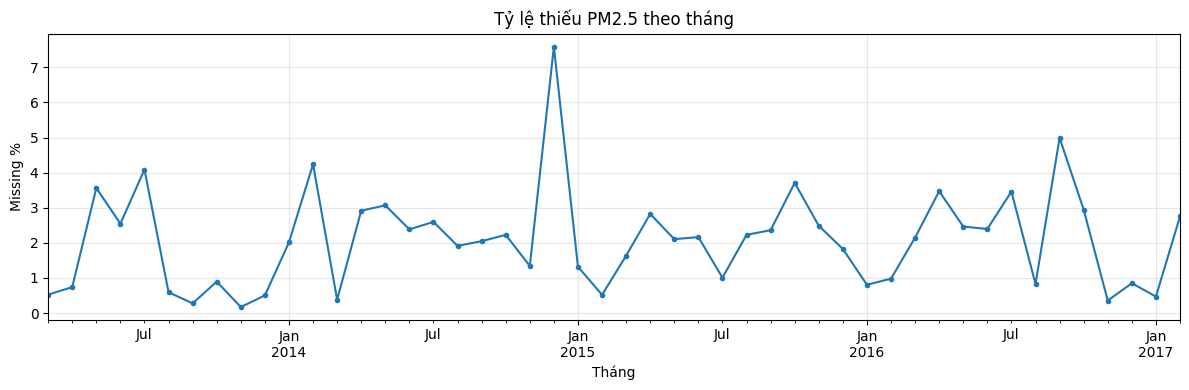


=> Kết luận: Thiếu dữ liệu rải đều


In [13]:
# 3. Thiếu dữ liệu theo thời gian (PM2.5)
print("\n" + "="*60)
print("3. THIẾU DỮ LIỆU THEO THỜI GIAN (PM2.5)")
print("="*60)

# Tạo cột để đánh dấu thiếu
df_temp = df.copy()
df_temp['is_missing_pm25'] = df_temp['PM2.5'].isna()

# Nhóm theo tháng để xem thiếu tập trung ở đâu
df_temp['year_month'] = df_temp['datetime'].dt.to_period('M')
missing_by_month = df_temp.groupby('year_month')['is_missing_pm25'].agg(['sum', 'count', 'mean'])
missing_by_month.columns = ['Missing', 'Total', 'Missing_Rate']
missing_by_month['Missing_Rate'] = missing_by_month['Missing_Rate'] * 100

print("Top 10 tháng thiếu PM2.5 nhiều nhất:")
print(missing_by_month.sort_values('Missing_Rate', ascending=False).head(10))

fig, ax = plt.subplots(figsize=(12, 4))
missing_by_month['Missing_Rate'].plot(ax=ax, marker='o', markersize=3)
ax.set_title('Tỷ lệ thiếu PM2.5 theo tháng')
ax.set_ylabel('Missing %')
ax.set_xlabel('Tháng')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=> Kết luận: Thiếu dữ liệu", "rải đều" if missing_by_month['Missing_Rate'].std() < 2 else "tập trung vào một số giai đoạn")


4. PHÂN PHỐI VÀ NGOẠI LAI (PM2.5)
count    412029.000000
mean         79.793428
std          80.822391
min           2.000000
5%            6.000000
25%          20.000000
50%          55.000000
75%         111.000000
95%         242.000000
99%         370.000000
max         999.000000
Name: PM2.5, dtype: float64

Phân tích phân phối:
- Mean (79.79) > Median (55.00)
- Q3-Q1 (IQR) = 91.00
- 95th percentile: 242.00
- 99th percentile: 370.00
- Max: 999.00

=> Phân phối lệch phải (skewed right) với đuôi dài, có spike cao


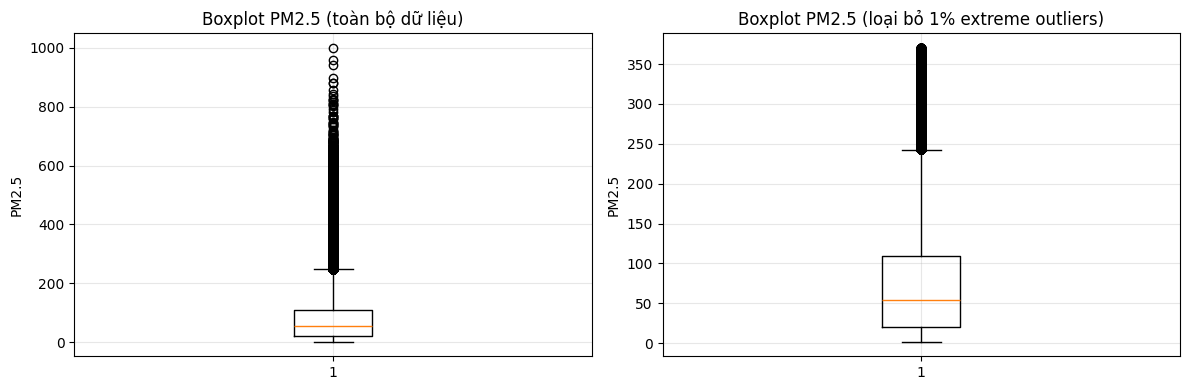

In [14]:
# 4. Boxplot và quantile để nhìn ngoại lai
print("\n" + "="*60)
print("4. PHÂN PHỐI VÀ NGOẠI LAI (PM2.5)")
print("="*60)

pm25_clean = df['PM2.5'].dropna()
stats = pm25_clean.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print(stats)

print(f"\nPhân tích phân phối:")
print(f"- Mean ({stats['mean']:.2f}) > Median ({stats['50%']:.2f})")
print(f"- Q3-Q1 (IQR) = {stats['75%'] - stats['25%']:.2f}")
print(f"- 95th percentile: {stats['95%']:.2f}")
print(f"- 99th percentile: {stats['99%']:.2f}")
print(f"- Max: {stats['max']:.2f}")
print(f"\n=> Phân phối lệch phải (skewed right) với đuôi dài, có spike cao")

# Boxplot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot toàn bộ
axes[0].boxplot(pm25_clean, vert=True)
axes[0].set_ylabel('PM2.5')
axes[0].set_title('Boxplot PM2.5 (toàn bộ dữ liệu)')
axes[0].grid(True, alpha=0.3)

# Boxplot loại bỏ outliers cực đoan (để nhìn rõ hơn)
pm25_95 = pm25_clean[pm25_clean <= pm25_clean.quantile(0.99)]
axes[1].boxplot(pm25_95, vert=True)
axes[1].set_ylabel('PM2.5')
axes[1].set_title('Boxplot PM2.5 (loại bỏ 1% extreme outliers)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


5. VẼ CHUỖI PM2.5 THEO THỜI GIAN


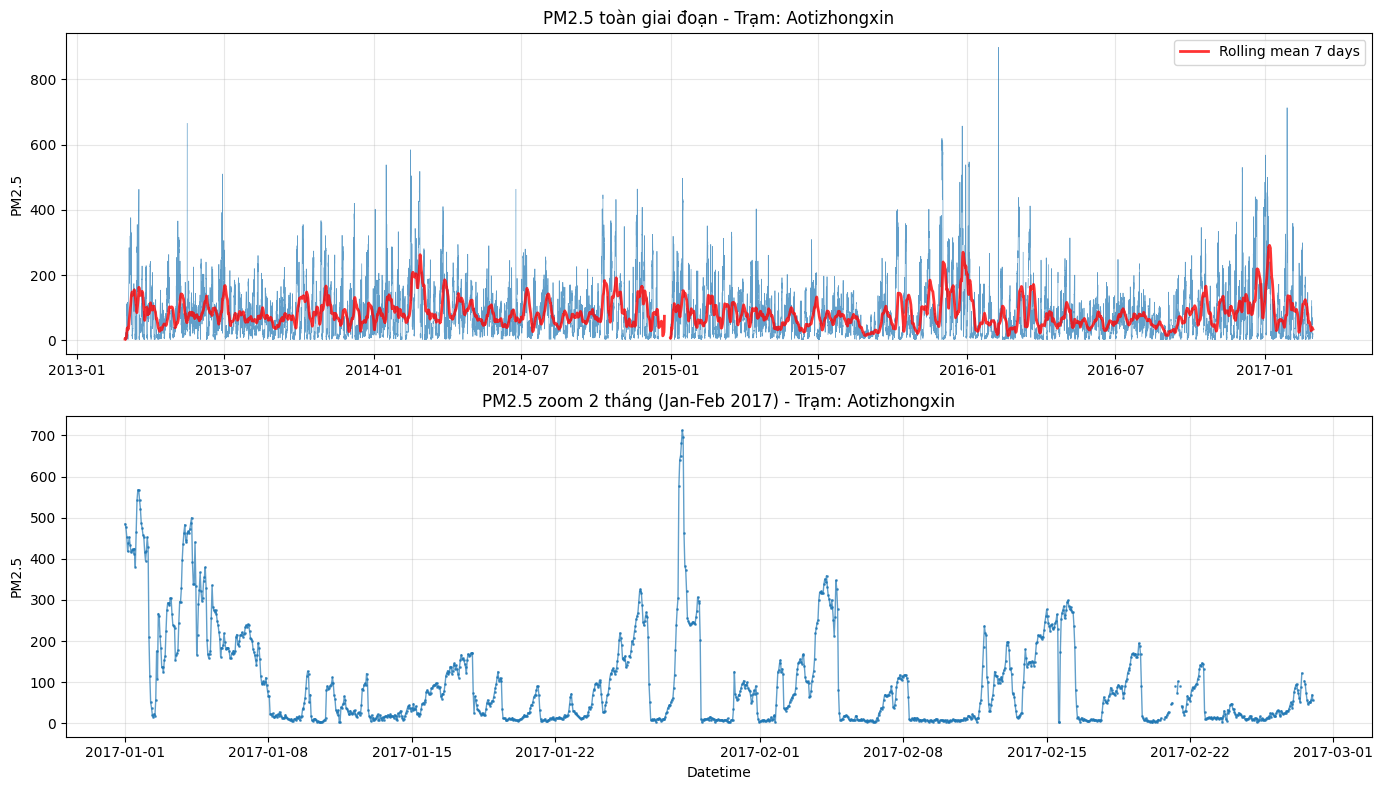


=> Từ biểu đồ trên, ta thấy:
   - Chuỗi có biến động mạnh theo thời gian
   - Có các đỉnh spike (PM2.5 rất cao)
   - Rolling mean cho thấy xu hướng theo mùa


In [15]:
# 5. Vẽ chuỗi PM2.5 theo thời gian
print("\n" + "="*60)
print("5. VẼ CHUỖI PM2.5 THEO THỜI GIAN")
print("="*60)

# Lấy 1 trạm để vẽ (sử dụng lại station_df từ cell 1)
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 5a. Toàn giai đoạn
axes[0].plot(station_df['datetime'], station_df['PM2.5'], linewidth=0.5, alpha=0.7)
axes[0].set_title(f'PM2.5 toàn giai đoạn - Trạm: {sample_station}')
axes[0].set_ylabel('PM2.5')
axes[0].grid(True, alpha=0.3)

# Thêm rolling mean để nhìn xu hướng
station_df_temp = station_df.set_index('datetime')
rolling_7d = station_df_temp['PM2.5'].rolling(window=24*7, min_periods=1).mean()
axes[0].plot(rolling_7d.index, rolling_7d.values, 'r-', linewidth=2, label='Rolling mean 7 days', alpha=0.8)
axes[0].legend()

# 5b. Zoom vào 2 tháng (chọn tháng 1-2/2017 - gần test set)
zoom_start = '2017-01-01'
zoom_end = '2017-02-28'
zoom_df = station_df[(station_df['datetime'] >= zoom_start) & (station_df['datetime'] <= zoom_end)]

axes[1].plot(zoom_df['datetime'], zoom_df['PM2.5'], linewidth=1, marker='o', markersize=1, alpha=0.7)
axes[1].set_title(f'PM2.5 zoom 2 tháng (Jan-Feb 2017) - Trạm: {sample_station}')
axes[1].set_ylabel('PM2.5')
axes[1].set_xlabel('Datetime')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=> Từ biểu đồ trên, ta thấy:")
print("   - Chuỗi có biến động mạnh theo thời gian")
print("   - Có các đỉnh spike (PM2.5 rất cao)")
print("   - Rolling mean cho thấy xu hướng theo mùa")


6. KIỂM TRA TỰ TƯƠNG QUAN
          Autocorrelation
lag_1h           0.966572
lag_3h           0.878501
lag_6h           0.759069
lag_12h          0.591005
lag_24h          0.393293
lag_48h          0.136408
lag_72h          0.059083
lag_168h         0.016149

** Phân tích tự tương quan:
   - Lag 1h: 0.967 (rất cao - giá trị hiện tại phụ thuộc mạnh vào giờ trước)
   - Lag 24h: 0.393 (chu kỳ ngày)
   - Lag 168h: 0.016 (chu kỳ tuần)

=> Kết luận: Chuỗi có tự tương quan mạnh, đặc biệt ở lag ngắn và chu kỳ ngày/tuần


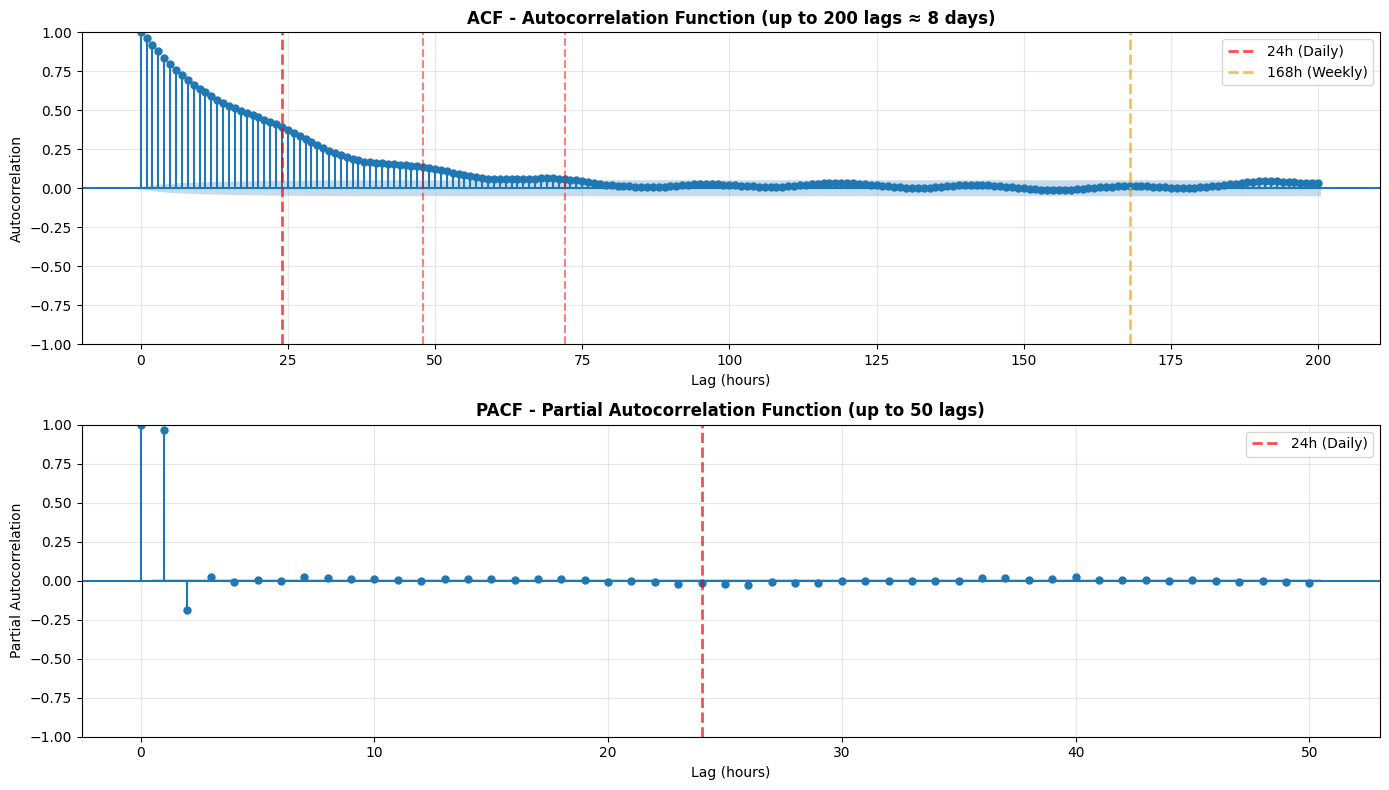


** Nhận xét từ ACF/PACF plot:
   - ACF: Giảm chậm, có đỉnh lặp lại ở lag 24h, 48h... → chu kỳ ngày rõ ràng
   - ACF tại lag 168h vẫn dương → có dấu hiệu chu kỳ tuần (yếu hơn)
   - PACF: Cắt đột ngột sau lag 1-3 → gợi ý AR order thấp (p=1 hoặc 2)
   - Kết hợp → ARIMA cần d≥1 (vì ACF giảm chậm), có thể cần xét SARIMA với s=24


In [16]:
# 6. Kiểm tra tự tương quan (Autocorrelation)
print("\n" + "="*60)
print("6. KIỂM TRA TỰ TƯƠNG QUAN")
print("="*60)

# Lấy chuỗi PM2.5 sạch (sử dụng station_df từ cell trước)
pm25_series = station_df.set_index('datetime')['PM2.5'].dropna()

# Tính autocorrelation ở các lag quan trọng
lags_to_check = [1, 3, 6, 12, 24, 48, 72, 168]  # 168h = 1 tuần
autocorr_results = {}
for lag in lags_to_check:
    autocorr_results[f'lag_{lag}h'] = pm25_series.autocorr(lag=lag)

autocorr_df = pd.DataFrame.from_dict(autocorr_results, orient='index', columns=['Autocorrelation'])
print(autocorr_df)

print(f"\n** Phân tích tự tương quan:")
print(f"   - Lag 1h: {autocorr_results['lag_1h']:.3f} (rất cao - giá trị hiện tại phụ thuộc mạnh vào giờ trước)")
print(f"   - Lag 24h: {autocorr_results['lag_24h']:.3f} (chu kỳ ngày)")
print(f"   - Lag 168h: {autocorr_results['lag_168h']:.3f} (chu kỳ tuần)")
print(f"\n=> Kết luận: Chuỗi có tự tương quan mạnh, đặc biệt ở lag ngắn và chu kỳ ngày/tuần")

# Vẽ ACF và PACF để trực quan hóa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# ACF plot
plot_acf(pm25_series, lags=200, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF - Autocorrelation Function (up to 200 lags ≈ 8 days)', fontsize=12, fontweight='bold')
axes[0].axvline(x=24, color='red', linestyle='--', linewidth=2, alpha=0.7, label='24h (Daily)')
axes[0].axvline(x=48, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].axvline(x=72, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].axvline(x=168, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='168h (Weekly)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylabel('Autocorrelation')
axes[0].set_xlabel('Lag (hours)')

# PACF plot
plot_pacf(pm25_series, lags=50, ax=axes[1], alpha=0.05)
axes[1].set_title('PACF - Partial Autocorrelation Function (up to 50 lags)', fontsize=12, fontweight='bold')
axes[1].axvline(x=24, color='red', linestyle='--', linewidth=2, alpha=0.7, label='24h (Daily)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].set_xlabel('Lag (hours)')

plt.tight_layout()
plt.show()

print("\n** Nhận xét từ ACF/PACF plot:")
print("   - ACF: Giảm chậm, có đỉnh lặp lại ở lag 24h, 48h... → chu kỳ ngày rõ ràng")
print("   - ACF tại lag 168h vẫn dương → có dấu hiệu chu kỳ tuần (yếu hơn)")
print("   - PACF: Cắt đột ngột sau lag 1-3 → gợi ý AR order thấp (p=1 hoặc 2)")
print("   - Kết hợp → ARIMA cần d≥1 (vì ACF giảm chậm), có thể cần xét SARIMA với s=24")

In [17]:
# 7. Kiểm tra tính dừng (Stationarity) - ADF và KPSS
print("\n" + "="*60)
print("7. KIỂM ĐỊNH TÍNH DỪNG (STATIONARITY)")
print("="*60)

%pip install statsmodels
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test (sử dụng pm25_series từ cell trước)
adf_result = adfuller(pm25_series, autolag='AIC')
print("ADF (Augmented Dickey-Fuller) Test:")
print(f"  ADF Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"  Critical values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("  => Bác bỏ H0 (có unit root), chuỗi có xu hướng DỪNG")
else:
    print("  => Không bác bỏ H0, chuỗi có xu hướng KHÔNG DỪNG")

# KPSS test
print("\nKPSS Test:")
kpss_result = kpss(pm25_series, regression='c', nlags='auto')
print(f"  KPSS Statistic: {kpss_result[0]:.4f}")
print(f"  p-value: {kpss_result[1]:.4f}")
print(f"  Critical values:")
for key, value in kpss_result[3].items():
    print(f"    {key}: {value:.4f}")

if kpss_result[1] > 0.05:
    print("  => Không bác bỏ H0 (dừng), chuỗi có xu hướng DỪNG")
else:
    print("  => Bác bỏ H0, chuỗi có xu hướng KHÔNG DỪNG")

print("\n" + "="*60)
print("KẾT LUẬN TỔNG HỢP Q1:")
print("="*60)
print("1. Dữ liệu: 420,768 dòng, 12 trạm, tần suất hourly liên tục 2013-2017")
print("2. Missing: PM2.5 thiếu ~2%, cần xử lý vì là biến mục tiêu dự báo")
print("3. Phân phối: Lệch phải với spike cao, cần lưu ý khi đánh giá (RMSE vs MAE)")
print("4. Xu hướng: Có biến động mạnh, rolling mean cho thấy pattern theo mùa")
print("5. Tự tương quan: Mạnh ở lag ngắn, có chu kỳ ngày (24h) và tuần (168h)")
print("6. Tính dừng: Cần kiểm tra kỹ (ADF/KPSS), có thể cần differencing (d>0)")
print("="*60)


7. KIỂM ĐỊNH TÍNH DỪNG (STATIONARITY)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\quang\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
ADF (Augmented Dickey-Fuller) Test:
  ADF Statistic: -19.5261
  p-value: 0.0000
  Critical values:
    1%: -3.4305
    5%: -2.8616
    10%: -2.5668
  => Bác bỏ H0 (có unit root), chuỗi có xu hướng DỪNG

KPSS Test:
  KPSS Statistic: 0.2008
  p-value: 0.1000
  Critical values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  => Không bác bỏ H0 (dừng), chuỗi có xu hướng DỪNG

KẾT LUẬN TỔNG HỢP Q1:
1. Dữ liệu: 420,768 dòng, 12 trạm, tần suất hourly liên tục 2013-2017
2. Missing: PM2.5 thiếu ~2%, cần xử lý vì là biến mục tiêu dự báo
3. Phân phối: Lệch phải với spike cao, cần lưu ý khi đánh giá (RMSE vs MAE)
4. Xu hướng: Có biến động mạnh, rolling mean cho thấy pattern theo mùa
5. Tự tương quan: Mạnh ở lag ngắn, có chu kỳ ngày (24h) và tuần (168h)
6. Tính dừng: Cần kiểm tra kỹ (ADF/KPSS), có thể cần differencing (d>0)


C:\Users\quang\AppData\Local\Temp\ipykernel_19600\2972977283.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(pm25_series, regression='c', nlags='auto')


In [28]:
df.to_parquet(OUT_PATH, index=False)
print('Saved:', OUT_PATH)

Saved: C:\Users\quang\OneDrive\Desktop\Code\KPDL\Lab4\data\processed\cleaned.parquet
